In [2]:
#import the libraries 
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack,signal
import matplotlib
from matplotlib.ticker import ScalarFormatter
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval)
import scipy
import json
import subprocess
import os
import emcee
import tqdm
import corner

from exocrires import spectra_2d
from exocrires import analysis
from exocrires import info

from astropy.io import fits
from astropy.table import Table

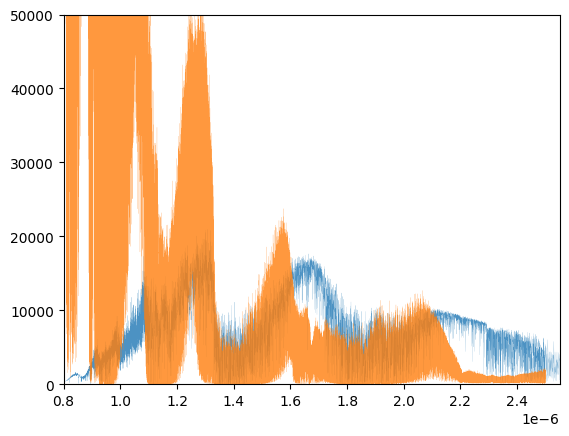

In [80]:
#Comapre Lorenzo Model with BT-Settl Model 
spec_BT_Settl=np.loadtxt(path+'thesis_ms/models_1683734698/bt-settl_m/lte014-4.0-0.0.BT-Settl.7.dat.txt.dat')
spec_lorenzo=np.load(path+'thesis_ms/f_pRT_t1400_g100nc_m0.0.npy')

plt.plot(spec_BT_Settl[:,0], spec_BT_Settl[:,1], linewidth=0.1, alpha=0.8)
plt.plot(wave, spec_lorenzo*1e-8, linewidth=0.1, alpha=0.8)
plt.xlim(0.8e-6, 2.55e-6)
plt.ylim(0, 5e4)
#plt.yscale('log')
plt.show()

# 1-1. Prepare BT-Settl Spectra
convert the wave and flux

In [ ]:
filenames=sorted(glob.glob('/Volumes/Macintosh HD/Users/richard/project_EXOCRIRES/thesis_ms/models_1683734698/bt-settl/*txt'))

i=0
for filename in filenames:

    data=np.loadtxt(filename)
    
    wave=data[:,0]*1e-10
    flux=data[:,1]
    
    data_convert=np.array([wave,flux]).T
    
    np.savetxt('/Volumes/Macintosh HD/Users/richard/project_EXOCRIRES/thesis_ms/models_1683734698/bt-settl_m_2/%s.dat'%filename[-33:], data_convert)
    
    i+=1

# 1-2. Prepare Lorenzo's Spectra
1-2-1 Match the wavelength \
1-2-2 Cut the spectra into separate bands and then Convolve with a Gaussian LSF \
1-2-3 Insert a velocity and shift the spectra \
1-2-4 Reduce the size of the dataset

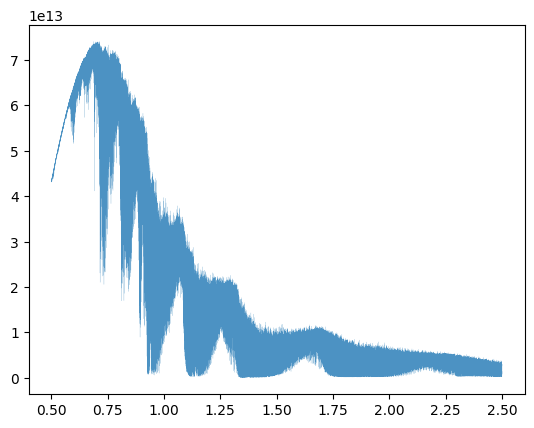

In [2]:
#Convert Lorenzo Spectra
#plot the forward model with T = 2200K

path='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/'
flux=np.load(path+'AB_aur/f_pRT_t2200_g31nc_m0.0.npy')
wave=np.load(path+'AB_Aur/wave_pRT_4.npy')

plt.plot(wave, flux, linewidth=0.1, alpha=0.8)
#plt.xlim(1.9, 2.2)
#plt.ylim(0, 4e-5)
plt.show()

1207078.7030402462


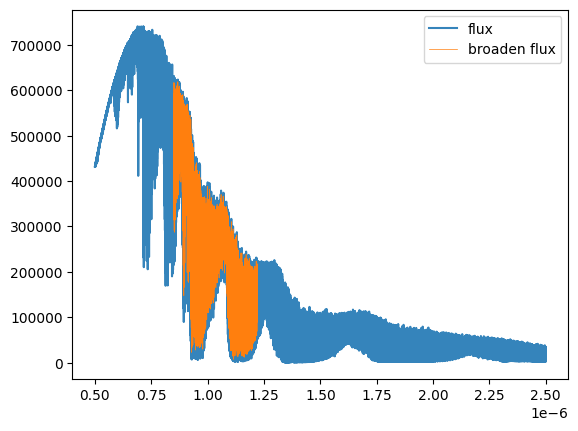

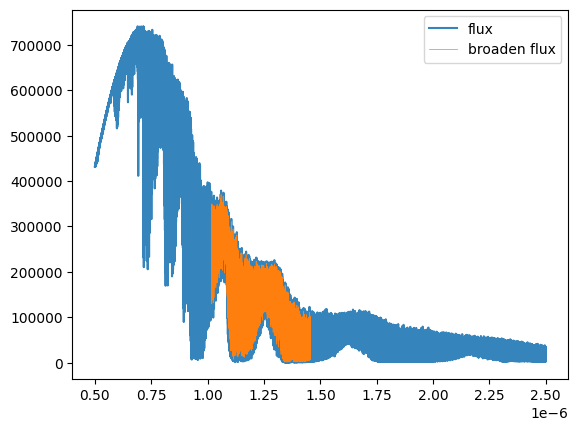

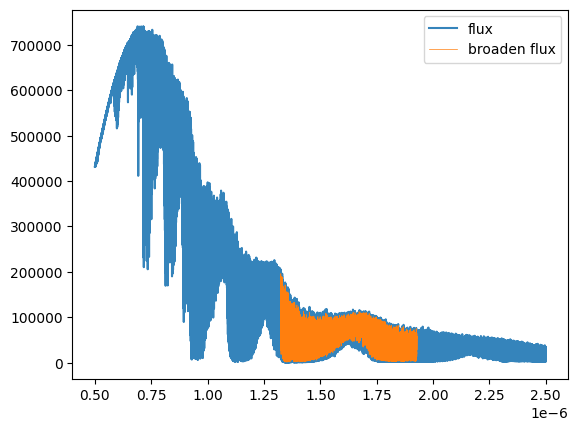

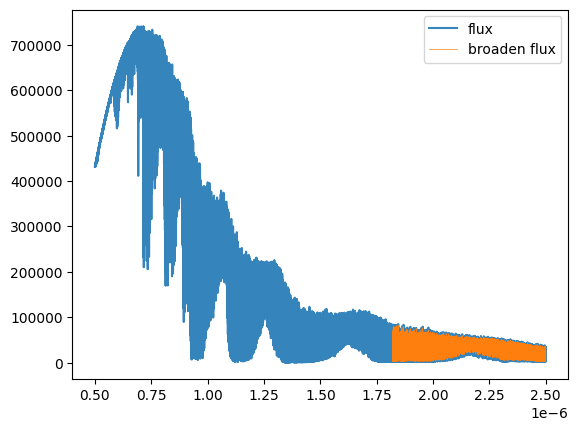

In [3]:
#Convolve a LSF
import scipy.ndimage

wave*=1e-6
flux*=1e-8 # Unit 

def gaussian_broaden_spectrum(wavelength, flux, R):
    # Convert wavelength to log space
    log_wavelength = np.log(wavelength)
    
    # Define FWHM and standard deviation in log space
    fwhm_log = 1 / R
    sigma_log = fwhm_log / 2.355  # Convert FWHM to sigma
    
    # Convolve the flux with a Gaussian kernel in log space
    broadened_flux = scipy.ndimage.gaussian_filter1d(flux, sigma=sigma_log / (log_wavelength[1] - log_wavelength[0]))
    
    return broadened_flux

def resolution_sample(ave_R, wavelength):
    
    lam_range=np.max(wavelength)-np.min(wavelength)
    
    lam_mid=(np.max(wavelength)+np.min(wavelength))/2
    
    N=ave_R*(lam_range/lam_mid)+1
    
    return (int(N))

# Example: wavelengths, fluxes, and resolution R
N_sample=len(wave)
lam_range=np.max(wave)-np.min(wave)
lam_mid=(np.max(wave)+np.min(wave))/2
R_sample =  (N_sample-1)/(lam_range/lam_mid)
print(R_sample)

R=1e5
reu=100 #redundant in nm


# Broaden the spectrum at separate bands and then reduce the size

for i in range(len(info.lambda_range['wave']))[0:4]:

    lam=info.lambda_range['wave'][i]

    mask=np.array((wave>=(lam[0][0]-reu)*1e-9) & (wave <=(lam[-1][-1]+reu)*1e-9))

    broadened_flux = gaussian_broaden_spectrum(wave[mask], flux[mask], R)

    plt.plot(wave, flux, label='flux', alpha=0.9)
    plt.plot(wave[mask], broadened_flux, label='broaden flux', linewidth=0.5)
    #plt.xlim(2.25315, 2.25325)
    #plt.ylim(0,1e13)
    
    plt.legend()
    plt.show()

    #----------

    N=resolution_sample(R*2, wave[mask])

    wave_grid=np.linspace(np.min(wave[mask]), np.max(wave[mask]), N)

    inter_flux=np.interp(wave_grid, wave[mask], broadened_flux)

    spec_lowres=np.array([wave_grid, inter_flux]).T
    np.savetxt(path+'/AB_aur/upload_lowres_%s.dat'%info.lambda_range['key'][i], spec_lowres)

In [137]:
#Convert into Fits

tab=Table(data=[wave_m, flux_m], names=('WAVE', 'FLUX'))

hdu=fits.BinTableHDU(tab)

hdu.writeto(path+'/AB_Aur/upload_update.fits', overwrite=True)

# 1-3. Prepare the PHOENIX spectrum

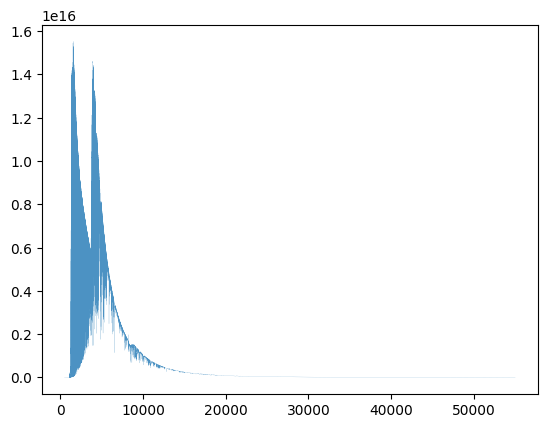

798959.2265859018


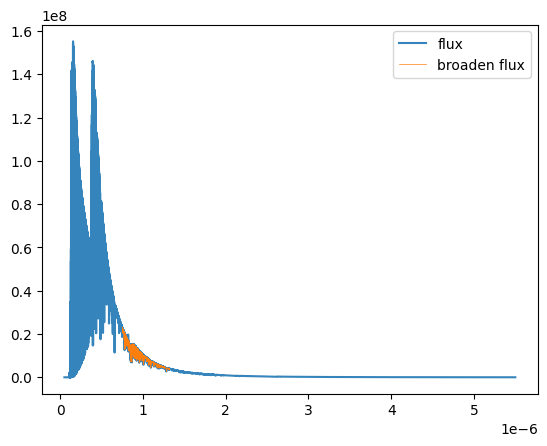

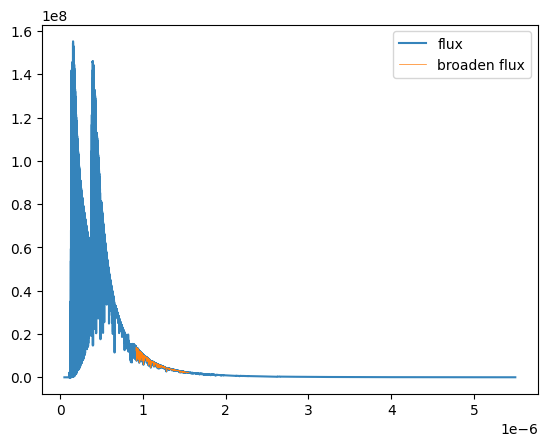

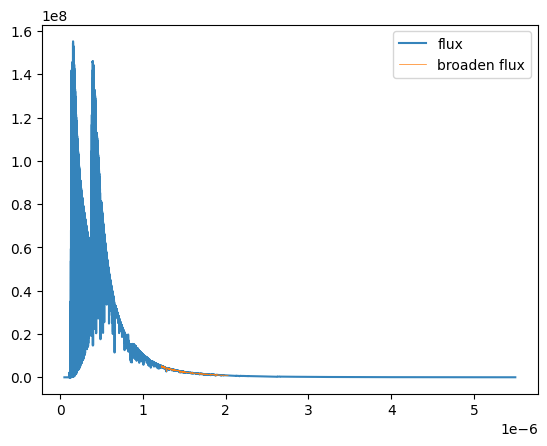

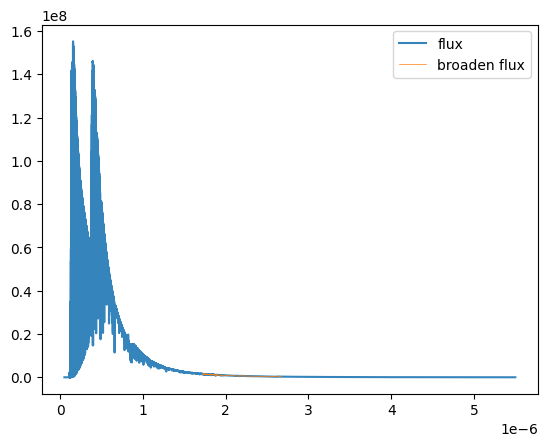

In [33]:
path='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/'
flux_hdu=fits.open(path+'AB_aur/lte09800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
wave_hdu=fits.open(path+'AB_Aur/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')

flux=flux_hdu[0].data
wave=wave_hdu[0].data

plt.plot(wave, flux, linewidth=0.1, alpha=0.8)
#plt.xlim(1.9, 2.2)
#plt.ylim(0, 4e-5)
plt.show()

#Convolve a LSF
import scipy.ndimage

wave*=1e-10 #m
flux*=1e-8 # erg/s/cm^2/A

def gaussian_broaden_spectrum(wavelength, flux, R):
    # Convert wavelength to log space
    log_wavelength = np.log(wavelength)
    
    # Define FWHM and standard deviation in log space
    fwhm_log = 1 / R
    sigma_log = fwhm_log / 2.355  # Convert FWHM to sigma
    
    # Convolve the flux with a Gaussian kernel in log space
    broadened_flux = scipy.ndimage.gaussian_filter1d(flux, sigma=sigma_log / (log_wavelength[1] - log_wavelength[0]))
    
    return broadened_flux

def resolution_sample(ave_R, wavelength):
    
    lam_range=np.max(wavelength)-np.min(wavelength)
    
    lam_mid=(np.max(wavelength)+np.min(wavelength))/2
    
    N=ave_R*(lam_range/lam_mid)+1
    
    return (int(N))

# Example: wavelengths, fluxes, and resolution R
N_sample=len(wave)
lam_range=np.max(wave)-np.min(wave)
lam_mid=(np.max(wave)+np.min(wave))/2
R_sample =  (N_sample-1)/(lam_range/lam_mid)
print(R_sample)

R=1e5
reu=200 #redundant in nm


# Broaden the spectrum at separate bands and then reduce the size

for i in range(len(info.lambda_range['wave']))[0:4]:

    lam=info.lambda_range['wave'][i]

    mask=np.array((wave >= (lam[0][0]-reu)*1e-9) & (wave <=(lam[-1][-1]+reu)*1e-9))

    broadened_flux = gaussian_broaden_spectrum(wave[mask], flux[mask], R)

    plt.plot(wave, flux, label='flux', alpha=0.9)
    plt.plot(wave[mask], broadened_flux, label='broaden flux', linewidth=0.5)
    
    #plt.xlim(2.25315, 2.25325)
    #plt.ylim(0,1e13)
    
    plt.legend()
    plt.show()

    #----------

    N=resolution_sample(R*2, wave[mask])

    wave_grid=np.linspace(np.min(wave[mask]), np.max(wave[mask]), N)

    inter_flux=np.interp(wave_grid, wave[mask], broadened_flux)

    spec_lowres=np.array([wave_grid, inter_flux]).T

    #spec = np.array([wave, broadened_flux]).T
    
    np.savetxt(path+'/AB_aur/upload_phoenix_%s.dat'%info.lambda_range['key'][i], spec_lowres)

# 2. Inject Velocity

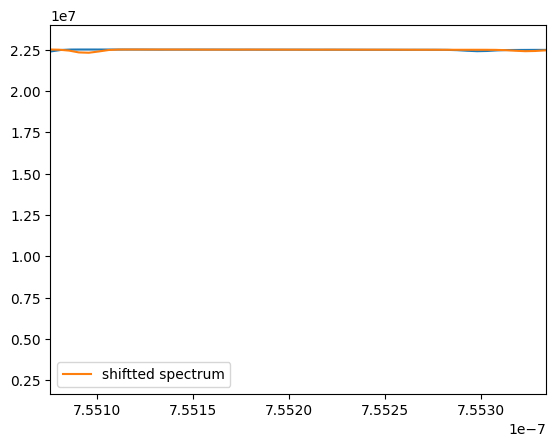

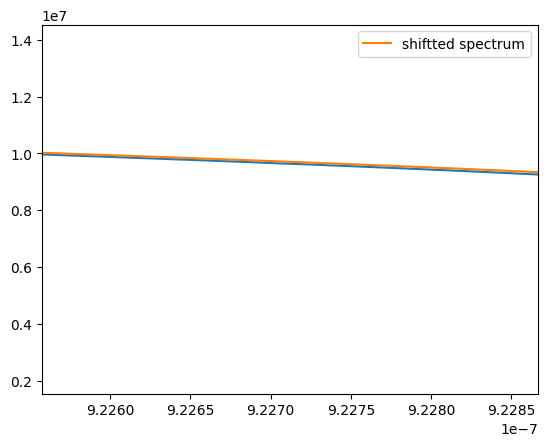

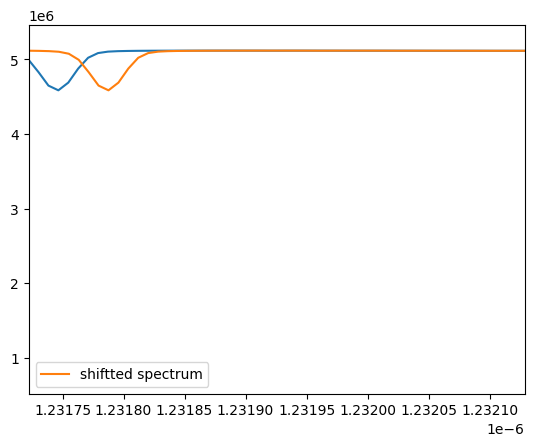

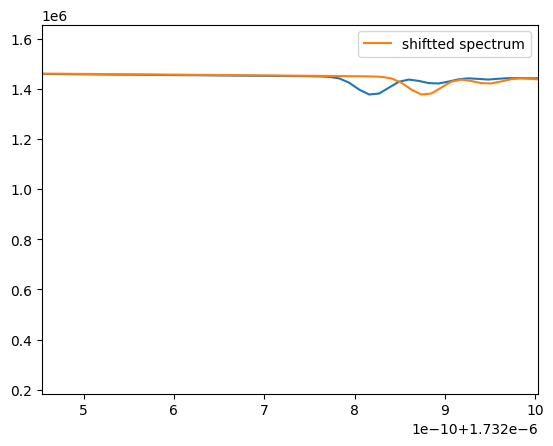

In [37]:
#everything here in SI units
v=10 #km/s

for i in range(len(info.lambda_range['wave']))[0:4]:
    
    data= np.loadtxt(path+'/AB_aur/upload_phoenix_%s.dat'%info.lambda_range['key'][i])
    wavelengths=data[:,0]
    flux=data[:,1]

    wavelengths_shift= wavelengths*(1+(v*1e3/scipy.constants.c))
    spec_shift=np.array([wavelengths_shift, flux]).T

    plt.plot(wavelengths, flux)
    plt.plot(wavelengths_shift, flux, label='shiftted spectrum')

    plt.xlim(wavelengths[1000], wavelengths[1000+50])
    plt.legend()
    plt.show()

    np.savetxt(path+'/AB_aur/upload_phoenix_%s_10km.dat'%info.lambda_range['key'][i], spec_shift)

# 3. Prepare the cube of model spectra

In [3]:
day='0611'
path='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES'
model_name='22-3.5-0.0'

data=np.loadtxt(path+'/AB_aur/upload_lowres_%s_10km.dat'%info.lambda_range['key'][-2])
transmission=np.load(path+'/AB_aur/%s/sky_noi/%s/transmission.npy'%(day, info.lambda_range['key'][-2]))

model_matrix=np.zeros(shape=(transmission.shape))

for i in range(7):

    mask=np.array((data[:,0]>=np.min(transmission[i,:, 0]))&(data[:,0]<=np.max(transmission[i,:, 0])))
    spec_inter=np.interp(transmission[i,:, 0], data[mask][:,0], data[mask][:,1])

    model_matrix[i,:, 0]=transmission[i,:,0]

    model_matrix[i,:, 1]=spec_inter

np.save(path+'/AB_aur/%s/planet/%s/%s/model_planet_matrix_10km.npy'%(day, model_name, info.lambda_range['key'][-2]), model_matrix)

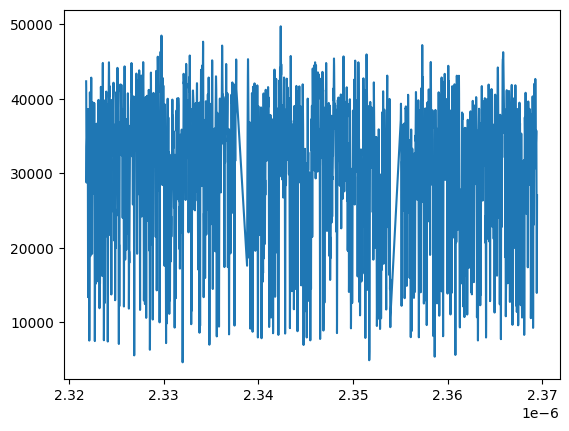

In [4]:
plt.plot(model_matrix[-2,0:6138,0], model_matrix[-2,0:6138,1])